## Project: Toxic Comment Filter

Costruire un modello in grado di filtrare i commenti degli utenti in base al grado di dannosità del linguaggio:
1. Preprocessare il testo eliminando l'insieme di token che non danno contributo significativo a livello semantico
2. Trasformare il corpus testuale in sequenze
3. Costruire un modello di Deep Learning comprendente dei layer ricorrenti per un task di classificazione multilabel
4. In prediction time, il modello deve ritornare un vettore contenente un 1 o uno 0 in corrispondenza di ogni label presente nel dataset (toxic,	severe_toxic,	obscene,	threat,	insult,	identity_hate). In questo modo, un commento non dannoso sarà classificato da un vettore di soli 0 [0,0,0,0,0,0]. Al contrario, un commento pericoloso presenterà almeno un 1 tra le 6 labels.

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Input, GRU, Bidirectional, Embedding, Dense, TextVectorization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import re
import nltk
from nltk.corpus import stopwords

RANDOM_SEED = 42

In [2]:

BASE_URL = "https://s3.eu-west-3.amazonaws.com/profession.ai/datasets/"
df = pd.read_csv(BASE_URL+"Filter_Toxic_Comments_dataset.csv")

In [3]:
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0


In [4]:
X = df["comment_text"].values
y = df.drop(["comment_text","sum_injurious"],axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

print(f"Train shapes, X:{X_train.shape}, y: {y_train.shape}")
print(f"Test shapes, X:{X_test.shape}, y: {y_test.shape}")

Train shapes, X:(127656,), y: (127656, 6)
Test shapes, X:(31915,), y: (31915, 6)


## Preprocessing
Provided dataset contains a lot of noise, meaning that there are a lot of words and punctuation that aren't useful for classification.

In text classification is crucial removing such words and punctuation, since the model could learn them, getting confused about text context.

In this project the preprocessing consists in 3 steps:
1. Lower text (Uppercase text is useless to catch the meaning of the phrase).
1. Remove punctuation and other symbols that are imported from "copy-paste" operation while building dataset: since comments are extracted from a web blog, some of them have symbols and numbers coming from a logging-like system (like timestamps, ip addresses or URLs). Again these terms are noise regarding the context.
1. Remove common english [stopwords](https://kavita-ganesan.com/what-are-stop-words/): these words are commonly used in written or oral communication (since they're fundamental for grammar rules), but they have low discriminating power regarding the text meaning (in a classification task). Examples of stopwords are prepositions and coordinating conjunctions.

Preprocessing can be considered a data-cleaning phase, where unnecessary words are filtered from corpus. To accomplish it, the nltk lib is used, in conjucntion with `re` python package.

Notice how the preprocessing is data-independent, i.e. there isn't a transformer that is fitted on data (like in numerical normalization for example).

In [5]:
#download common stopwords list using nltk utility
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
def clean_text(text):
    """
    Utility custom function to clean a single text string.
    Text is cleaned from punctuation, english common stopwords and
    is lowered.

    Parameters:
    - text (string): English text to be cleaned

    Return:
    Cleaned text as string.
    """
    # lowercase
    text = text.lower()

    # remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Remove text in square brackets
    text = re.sub(r'\[.*?\]', '', text)

    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Remove HTML tags
    text = re.sub(r'<.*?>+', '', text)

    # split text using any whitespace separator (including \n)
    words = text.split()

    # remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    #join words in a string
    return ' '.join(words)

Apply custom preprocessing function and collect new records in a new dataframe column.

In [7]:
df["comment_text_clean"] = df["comment_text"].apply(clean_text)

#check
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious,comment_text_clean
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,explanation edits made username hardcore metal...
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,daww matches background colour im seemingly st...
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,hey man im really trying edit war guy constant...
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,cant make real suggestions improvement wondere...
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,sir hero chance remember page thats


### Preprocessing outcome
The main outcome of this data cleaning is to rremove useless words and characters, thus shortening strings.
In the following cells there is a comparison between strings' lenghts before and after cleaning.

In [8]:
#define two utility variables
raw_len = df["comment_text"].apply(len)
clean_len = df["comment_text_clean"].apply(len)

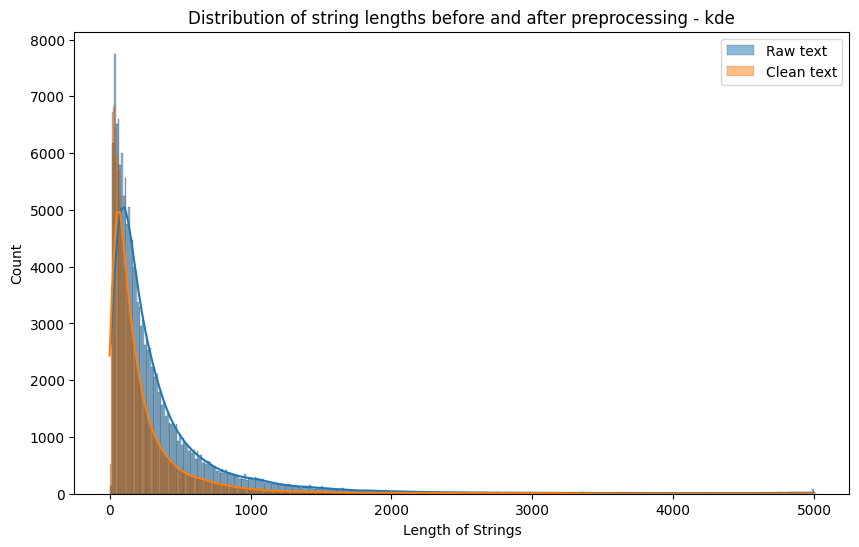

In [9]:
plt.figure(figsize=(10,6))
sns.histplot(x=raw_len, label="Raw text", kde=True)
sns.histplot(x=clean_len, label="Clean text", kde=True)
plt.legend()
plt.xlabel('Length of Strings')
plt.title('Distribution of string lengths before and after preprocessing - kde')
plt.show()

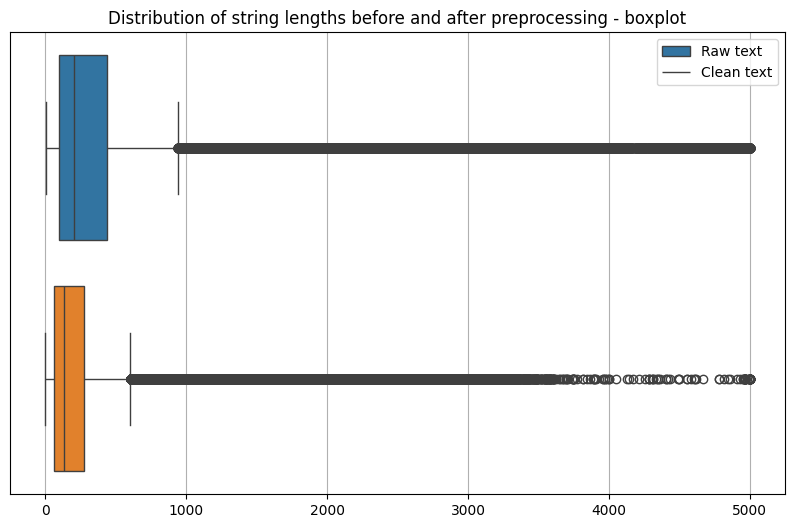

In [10]:
plt.figure(figsize=(10,6))
sns.boxplot(data=[raw_len.values, clean_len.values], orient="h")
plt.legend(["Raw text","Clean text"])
plt.title('Distribution of string lengths before and after preprocessing - boxplot')
plt.yticks([])
plt.gca().grid(True)
plt.show()

In [11]:
print("Text lenght summary stats:")
#define a temporary dataframe only for visualization purposes
pd.DataFrame([raw_len.describe(),clean_len.describe()])

Text lenght summary stats:


,count,mean,std,min,25%,50%,75%,max
comment_text,159571.0,394.073221,590.720282,6.0,96.0,205.0,435.0,5000.0
comment_text_clean,159571.0,254.817862,396.301048,0.0,60.0,131.0,278.0,5000.0


As one can see from charts and above dataframe, the dataset has same numerosity (no records have been removed), but the leght distribution changes:

after cleaning, the distribution (orange in charts) is "more left compressed", i.e. statistical parameters decrease, and in particular the mean value and the standard deviation; this prove that in in original comments, there were a bunch of useless character (coming from copy-paste operation from logs) and stop words (as usual in human readable text). The lenght reduction will help the model in detecting text meaning more precisely, without getting confused by noise.

According to boxplots there are a lot of outliers, but without additional information about lenght validity, one cannot consider these records as invalid, hence they are kept as is.

After this cleaning some strings have null lenght, in fact the minimum lenght value now is 0 (before it was 6), meaning that in original dataset there were some comments with only "useless" words and/or character.
A 0 lenght string is useless from model POV, since no sequence will be generated from it, then it's suitable remove these strings before moving on.

In [12]:
# Remove string with zero lenght after clean
df = df[clean_len != 0]

#check
print(df.shape)

#reassign utils variables
raw_len = df["comment_text"].apply(len)
clean_len = df["comment_text_clean"].apply(len)

(159552, 9)


Lucky these strings were only 19 records in total.

## Dataset split
Here `train_test_split` from sklearn is used twice to get train, validation and test set. They will be used during model training.

In [13]:
df_train_val, df_test = train_test_split(df, test_size=0.2,
                                         random_state=RANDOM_SEED)

df_train, df_valid = train_test_split(df_train_val, test_size=0.25,
                                   random_state=RANDOM_SEED)
#60 % train, 20 % valid, 20% test

#check
print(f"Train df shape: {df_train.shape}")
print(f"Test df shape: {df_test.shape}")
print(f"Valid df shape: {df_valid.shape}")


Train df shape: (95730, 9)
Test df shape: (31911, 9)
Valid df shape: (31911, 9)


Before moving on with numpy arrays, the 3-rd quartile of cleaned strings lenght is stored in a variable, since it will be used later; this value will be used as `output_sequence_length` parameters in
`TextVectorization`, i.e. the lenght of padded or truncated sequences (see [keras doc](https://keras.io/api/layers/preprocessing_layers/text/text_vectorization/) for further information).

In [14]:
lenght_q3_train = np.percentile(df_train["comment_text_clean"].apply(len),75).astype(int)

#check
print(lenght_q3_train)

278


Before moving on, one should check classes distribution.

In similar tasks quite often the dataset in unbalanced, and it's a problem during model fitting, since it could lead to overfitting.

To explore classes distribution we can use "sum_injurous" feature, that is a summary of possible records' classes: if this feature is 0, the record belongs to "neutral" class, in all other cases it belongs at least to one "toxic" class.

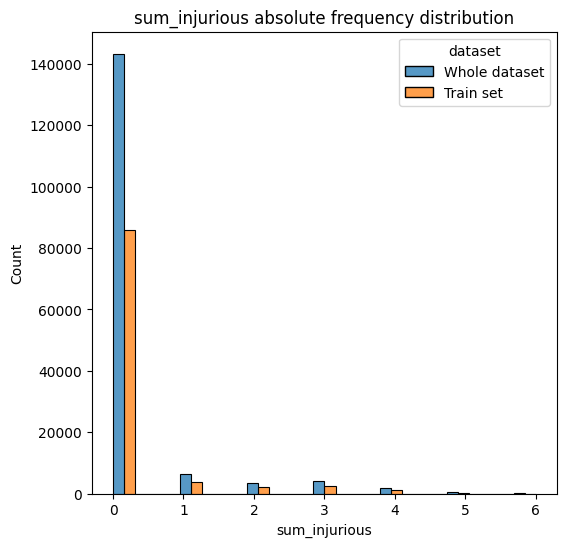

In [15]:
#temporary workaround to get a legend in histplot
df["dataset"] = 'Whole dataset'
df_train["dataset"] = 'Train set'
tmp_df = pd.concat([df,df_train])

#plot
plt.figure(figsize=(6,6))
sns.histplot(data=tmp_df, x="sum_injurious",
             hue="dataset", multiple="dodge")
plt.title("sum_injurious absolute frequency distribution")
plt.show()

#back to original dataframes
df.drop(["dataset"], axis=1, inplace=True)
df_train.drop(["dataset"], axis=1, inplace=True)

As one can sees, dataset is very unbalaced towards "neutral" class (i.e. sum_injurious = 0), meaning that most of comments aren't toxic at all.

This unbalace is present in train set too.

This unbalance is handled using a custom loss function that is the binary cross entropy but adjusted with some weights that are proportional to the inverse of classes frequency (see `custom_loss` function below for more details).

Using class weights is an approach to deal with imbalance, without modifing data, but rather assing a different penalty if there is an error in a less frequent class.

See also this topic on [stackOverflow](https://stackoverflow.com/questions/53860734/adding-class-weights-for-imbalanced-dataset-in-convolutional-neural-network) and on [data science stack-exchange](https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras).

In [16]:
#Get numpy ndarrays from dataframes
X_train = df_train["comment_text_clean"].values
y_train = df_train.drop(["comment_text","sum_injurious",\
                         "comment_text_clean"],
                        axis=1).values

X_test = df_test["comment_text_clean"].values
y_test = df_test.drop(["comment_text","sum_injurious",\
                         "comment_text_clean"],
                        axis=1).values

X_valid = df_valid["comment_text_clean"].values
y_valid = df_valid.drop(["comment_text","sum_injurious",\
                         "comment_text_clean"],
                        axis=1).values

## Model
The proposed model is a GRU-based RNN, with:
1. TextVecotrization layer to transfrom strings in int sequences
1. Embedding layer
1. Recursive layer made of GRU cells, wrapped in a Bidirectional layer
1. Dense layer with relu activation
1. Output layer, that is another dense layer with 6 neurons (each neuron computes a binary classification)

Moreover after Embedding and Bidirectional layer there is a Dropout layer with probability of $20\%$ in order to mitigate overfitting.

The model output is an array of 6 elements, where each element is the outcome of a binary classification: each output neuron provides the label for one o the 6 possible labels (this is a multi label problem).

The model structure is shown after the cell through the `plot_model` utility, and a `model.summary()` is printed below.

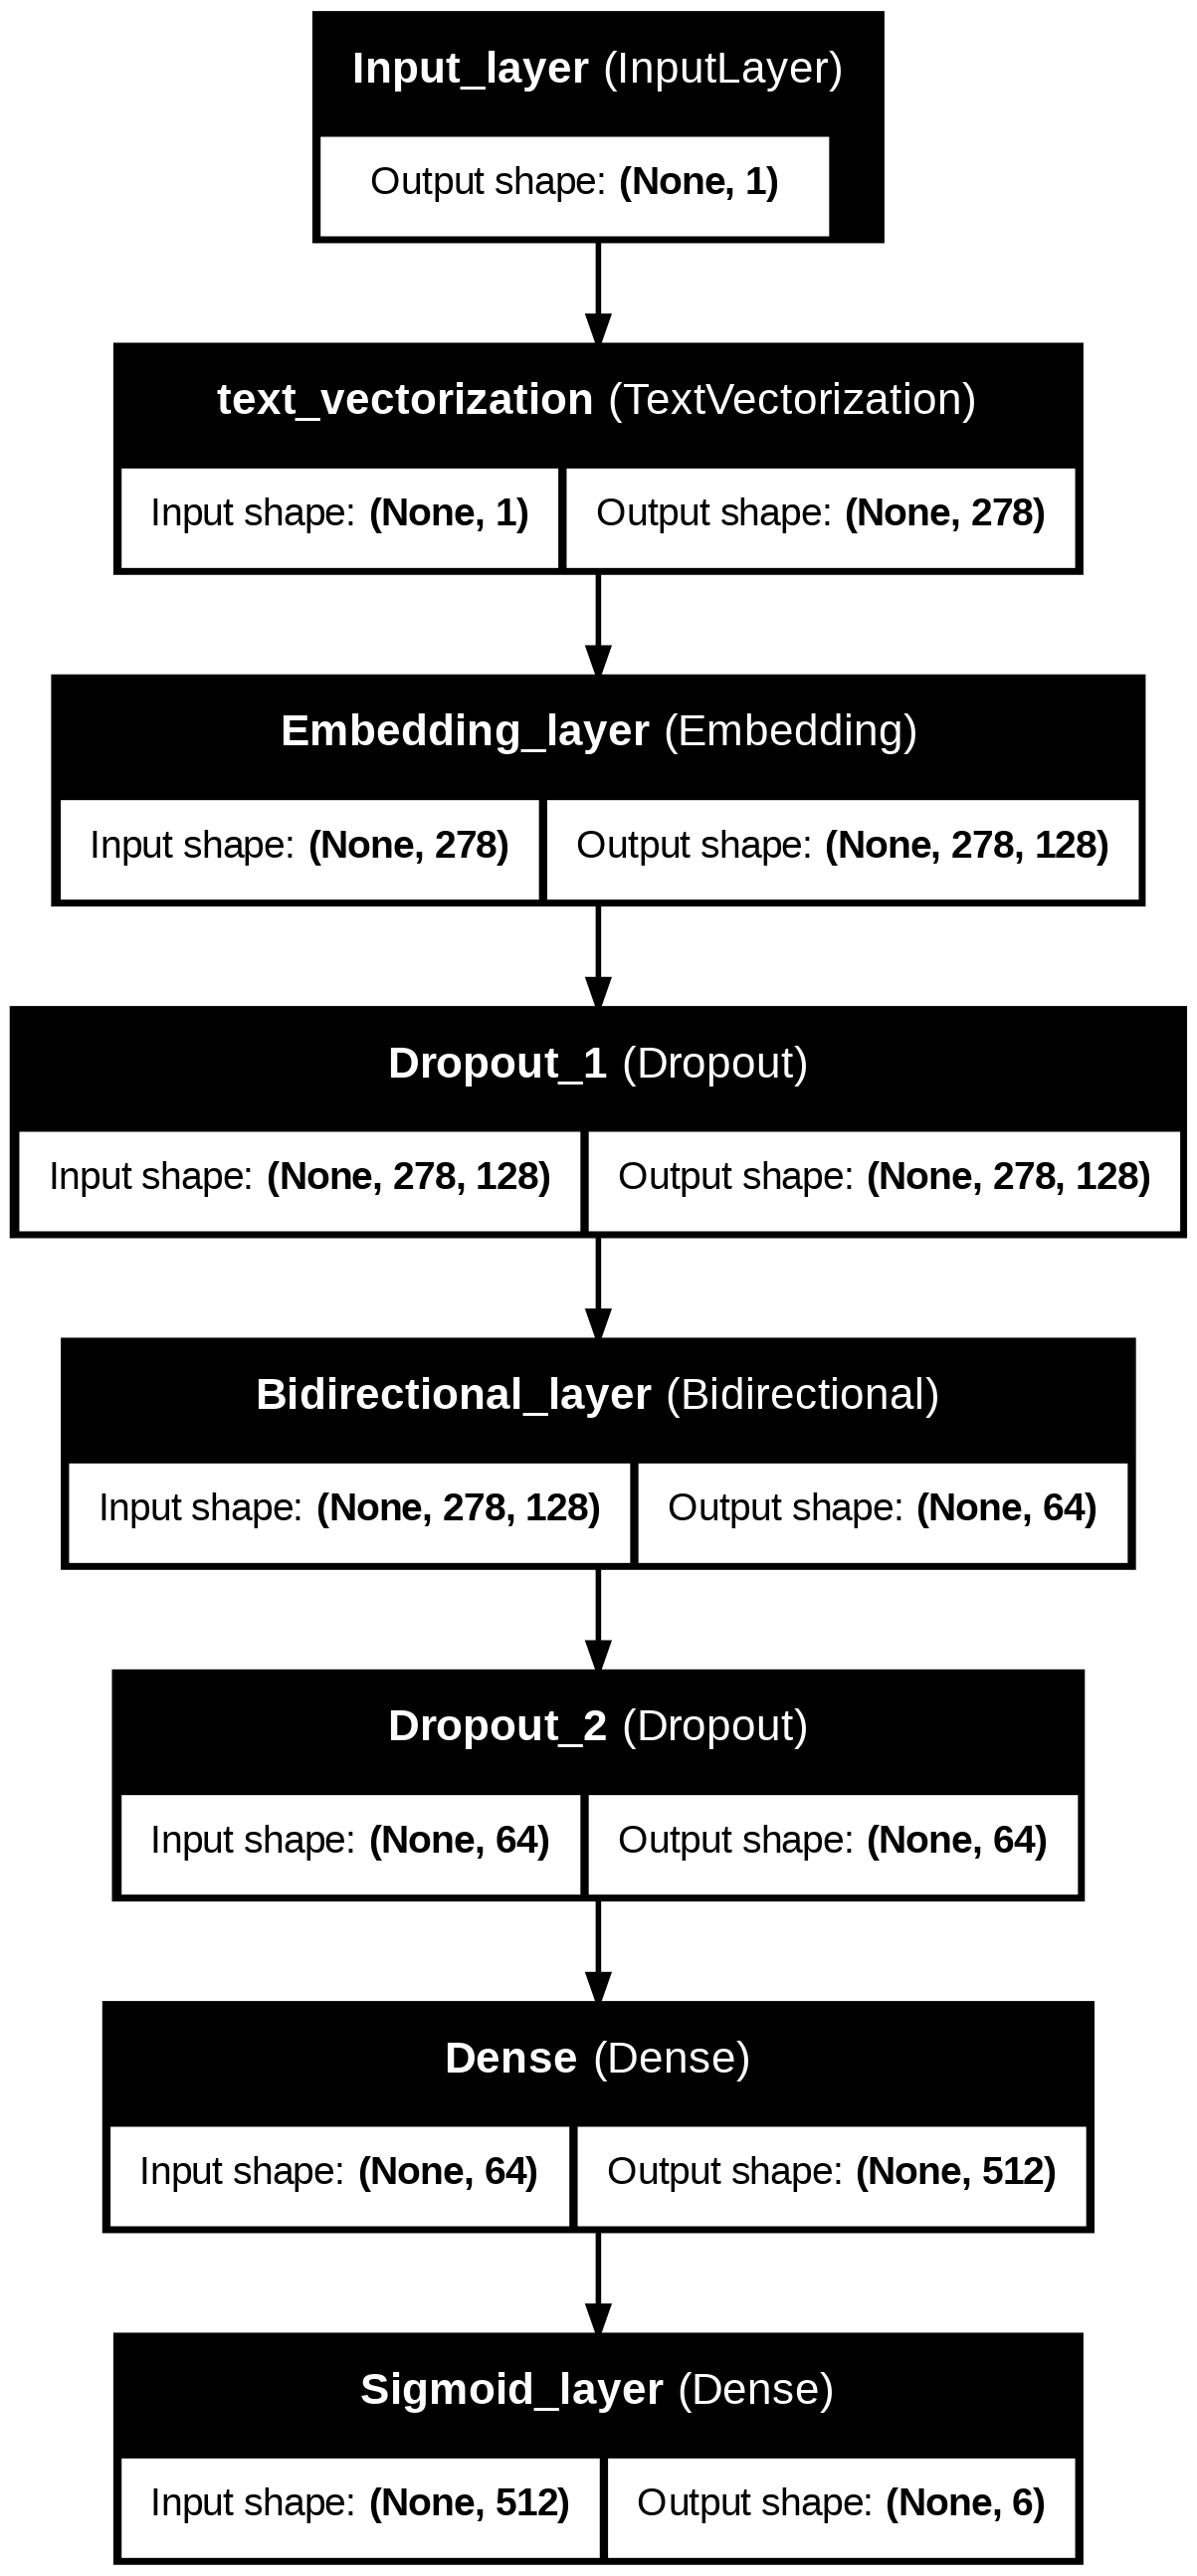

In [17]:
clear_session()

max_tokens = 10000 # max tokens numbers in vocabulary
max_len = int(lenght_q3_train) # max sequences lenght - use 3rd quartile of strings lenght (in train set)
embedding_dim = 128 # embedding dimension
rnn_dim = 32 #RNN layer dimension
dense_dim = 512 #Dense layer dimension

input_layer = Input(shape = (1,),dtype='string', name="Input_layer")

vectorize_layer = TextVectorization(max_tokens=max_tokens, output_mode='int', output_sequence_length=max_len)
vectorize_layer.adapt(X_train)
tmp = vectorize_layer(input_layer)

embedding_layer = Embedding(max_tokens, embedding_dim, name ="Embedding_layer")(tmp)
dropout_1 = Dropout(0.2, seed=RANDOM_SEED, name="Dropout_1")(embedding_layer)
recursive_layer = Bidirectional(GRU(rnn_dim, return_sequences=False,name="GRU"),name="Bidirectional_layer")(dropout_1)
dropout_2 = Dropout(0.2, seed=RANDOM_SEED, name="Dropout_2")(recursive_layer)
dense_layer = Dense(dense_dim, activation = 'relu', name ='Dense')(dropout_2)
output_layer = Dense(6,activation='sigmoid', name = "Sigmoid_layer")(dense_layer)

model = Model(inputs=input_layer, outputs=output_layer)

plot_file = 'model_plot_new.png'
plot_model(model, to_file=plot_file, show_shapes=True,
           show_layer_names=True)

Since we have a unbalanced dataset, during fit we use a custom loss function, that is the binary cross entropy but weighted according to classes frequency. Usually this is done through `class_weight` parameter of `compile` method, but it is designed for single-label problems, while here we have a multilabel problem (i.e. each record can have more than one label).

Weigths are computed for each label and the custom loss takes into account the multilabel problem.

In [18]:
import tensorflow.keras.backend as K


# compute weights for each label
label_weights = []
for i in range(y_train.shape[1]):
    label_counts = np.bincount(y_train[:, i])
    total_count = len(y_train)
    weights = {
        0: total_count / (2 * label_counts[0]),
        1: total_count / (2 * label_counts[1])
    }
    label_weights.append(weights)

# custom loss function
def custom_loss(y_true, y_pred):
    loss = 0
    for i in range(y_true.shape[1]):
        y_true_i = y_true[:, i]
        y_pred_i = y_pred[:, i]
        weights = label_weights[i]
        loss += -K.mean(weights[1] * y_true_i * K.log(y_pred_i + K.epsilon()) +
                        weights[0] * (1 - y_true_i) * K.log(1 - y_pred_i + K.epsilon()))
    return loss

In [19]:
model.compile(optimizer='adam', loss=custom_loss, metrics=['F1Score'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input_layer (InputLayer)             │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, 278)                 │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Embedding_layer (Embedding)          │ (None, 278, 128)            │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_1 (Dropout)                  │ (None, 278, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Bidirectional_layer (Bidirectional)  │ (None, 64)                  │          31,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense (Dense)                        │ (None, 512)                 │          33,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Sigmoid_layer (Dense)                │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,347,462 (5.14 MB)

 Trainable params: 1,347,462 (5.14 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
history = model.fit(X_train,y_train,epochs=7,batch_size=256, validation_data=(X_valid, y_valid))

Epoch 1/7
374/374 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - F1Score: 0.0719 - loss: 2.7235 - val_F1Score: 0.0286 - val_loss: 1.3303
Epoch 2/7
374/374 ━━━━━━━━━━━━━━━━━━━━ 37s 44ms/step - F1Score: 0.0318 - loss: 1.1567 - val_F1Score: 0.0286 - val_loss: 1.2265
Epoch 3/7
374/374 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - F1Score: 0.0295 - loss: 0.9363 - val_F1Score: 0.0286 - val_loss: 1.4196
Epoch 4/7
374/374 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - F1Score: 0.0313 - loss: 0.7815 - val_F1Score: 0.0333 - val_loss: 1.8221
Epoch 5/7
374/374 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - F1Score: 0.0758 - loss: 0.6600 - val_F1Score: 0.0795 - val_loss: 1.9514
Epoch 6/7
374/374 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - F1Score: 0.1085 - loss: 0.5750 - val_F1Score: 0.0923 - val_loss: 2.2700
Epoch 7/7
374/374 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - F1Score: 0.1733 - loss: 0.5117 - val_F1Score: 0.1287 - val_loss: 3.3898


Dealing with an imbalanced problem, accuracy isn't really suitable for this problem, but in this case F1Score is more valid.

As one can see from training logs, the F1Score is increasing both on train and validation datasets. From previous attempts it has emerged that over 7 epochs model tends to go in overfitting.

One should keep in mind that the F1Score computed by keras is only a reference, i.e. it's not detailed for each label, and for this reason a more accurate evaluation is done on test set, using `classification_report` by [scikit-learn](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.classification_report.html).

#### Note about val_loss
During fitting one can see that the `val_loss` (i.e. loss function computed on validation set at the epoch end) increases, but the `val_F1Score` (i.e. F1 score computed on validation set) improves too: althoug it seems strange, it may happen when dealing with imbalanced problems, and the reliable metrics is the F1 score in these cases.

In [21]:
def plot_learning_curve(history):
    plt.figure(figsize=(16,10))
    plt.subplot(2,1,1)
    plt.plot(history.history["loss"], label= "train")
    plt.plot(history.history["val_loss"], label = "valid")
    plt.xlabel("Epoch")
    plt.legend()
    plt.title("Loss")
    plt.subplot(2,1,2)
    plt.plot(np.mean(history.history["F1Score"],axis=1), label="train")
    plt.plot(np.mean(history.history["val_F1Score"],axis=1), label = "valid")
    plt.xlabel("Epoch")
    plt.legend()
    plt.title("F1Score")
    plt.show()

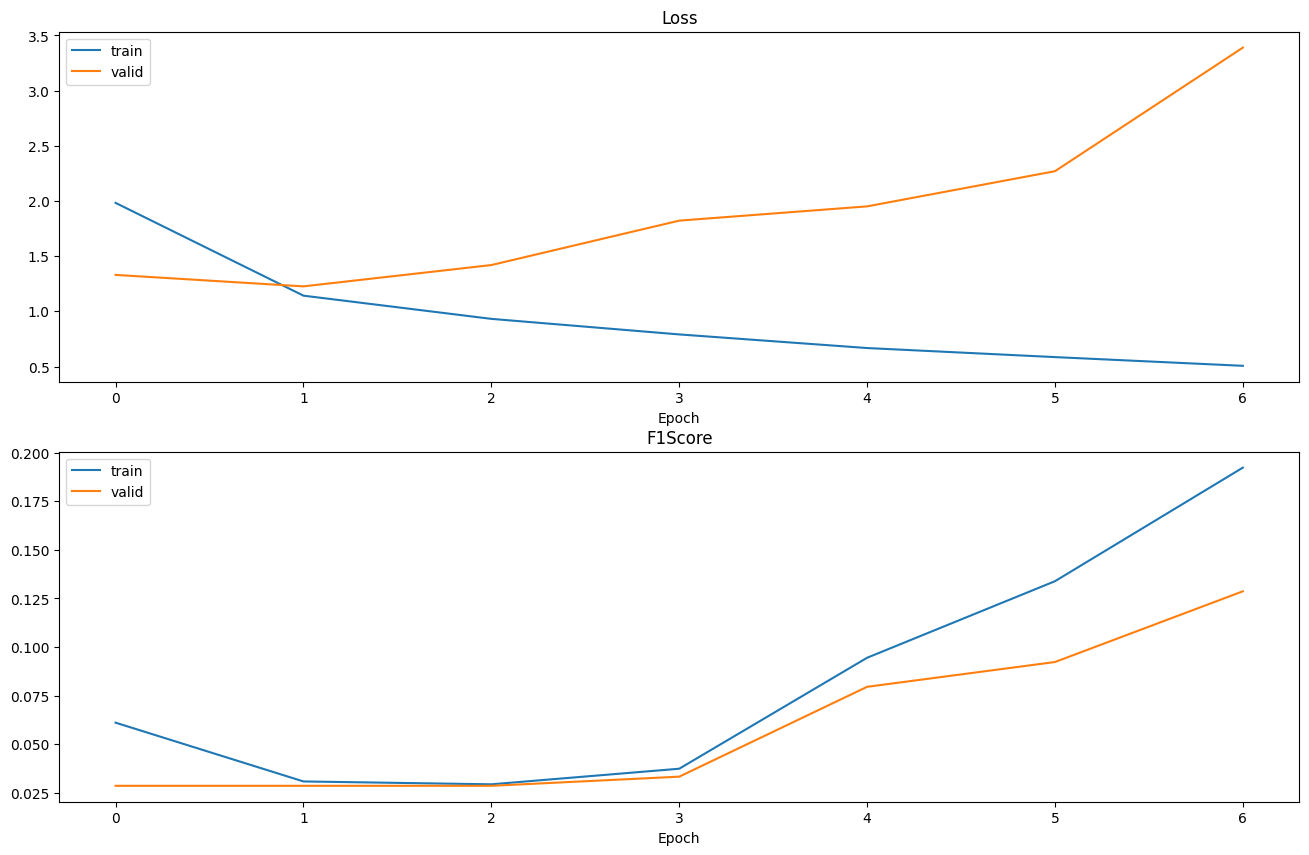

In [22]:
plot_learning_curve(history)

## Performance on test set

Once the model is fitted on training set, a final evaluation is done on test set.

The classification is performed using a classification threshold of $0.5$ and in final prediction array a column is added for the "neutral class" that is when all output neurons classify the record as negative (i.e. the same meaning of the provided dataset).

This additional column makes possible get more details about neutral class classification via sklearn `classification_report`.

In [23]:
y_pred = (model.predict(X_test) > 0.5).astype(int)

y_test_neutral = np.all(y_test == 0, axis=1).astype(int)
y_pred_neutral = np.all(y_pred == 0, axis=1).astype(int)

y_test_tmp = np.hstack([y_test,y_test_neutral.reshape(-1,1)])
y_pred_tmp = np.hstack([y_pred,y_pred_neutral.reshape(-1,1)])

#last column is the one for "neutral" class
print(classification_report(y_test_tmp,y_pred_tmp,target_names = ["toxic","severe_toxic","obscene","threat",\
                                                    "insult","identity_hate","neutral"]))

998/998 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step
               precision    recall  f1-score   support

        toxic       0.59      0.84      0.69      3049
 severe_toxic       0.22      0.92      0.36       321
      obscene       0.56      0.89      0.69      1739
       threat       0.11      0.58      0.18       103
       insult       0.45      0.89      0.60      1605
identity_hate       0.12      0.72      0.21       289
      neutral       0.98      0.94      0.96     28637

    micro avg       0.80      0.93      0.86     35743
    macro avg       0.43      0.83      0.53     35743
 weighted avg       0.89      0.93      0.89     35743
  samples avg       0.90      0.93      0.91     35743



### Outcome comments
The business metrics here is not accuracy since it's not a good metrics with an imbalanced dataset (see [here](https://binginagesh.medium.com/why-accuracy-is-bad-metric-for-imbalanced-datasets-7c1aad4cf12a) and [here](https://machinelearningmastery.com/failure-of-accuracy-for-imbalanced-class-distributions/)), while F1 score, recall and precision are less affected by imbalance (so they're more realiable here).

The best scores are computed on "neutral" class, since it's the most represented class (both on train and test set), while for less represented labels the metrics are lower (see "threat" and "identity_hate").

However one should keep in mind that this is a multi-label problem, where labels aren't mutually exclusive; since here one wants a model that is good in detecting several classes together one should focus on a metrics that is instance based, and not class based: this is the case of [sample averages](https://songstudio.info/tech/tech-37/). These averages are printed on bottom of `classification_report`.

In other words the business goal here is to correctly assign several classes to each instance, rather than focusing on single classes independently.  

Considering this the model performs good (with a sample weighted F1 score over $90\%$), although it can be however improved, by providing some additional comments belonging to "identity_hate" and "threat" classes.
